<a href="https://colab.research.google.com/github/Qiuyan918/Snapshot-Ensembles-Keras-Case-Study/blob/master/Snapshot_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.layers import Input, Dropout, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.initializers import glorot_uniform
from keras.models import Model, load_model, Sequential
from keras.callbacks import Callback
import keras.callbacks as callbacks
from keras import backend as K
from keras.optimizers import SGD
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from matplotlib import pyplot as plt
import math

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


# 1.Data


In [2]:
(trainX, trainY), (testX, testY) = cifar10.load_data()

print(f'trainX shape: {trainX.shape}')
print(f'testX shape: {testX.shape}')

170500096/170498071 [==============================] - 13s 0us/step
trainX shape: (50000, 32, 32, 3)
testX shape: (10000, 32, 32, 3)


In [3]:
trainY_cat = to_categorical(trainY)
testY_cat = to_categorical(testY)
print(trainY_cat)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [0]:
trainX = trainX.astype('float32')
trainX /= 255.0
testX = testX.astype('float32')
testX /= 255.0

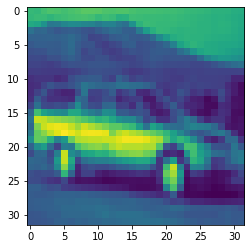

In [5]:
idx = 4
plt.imshow(trainX[idx][:,:,0])

# 2.Baseline

In [0]:
class LearningRateScheduler(Callback):
  def __init__(self, n_epochs, verbose=0):
    self.epochs = n_epochs
    self.lrates = list()

  def lr_scheduler(self, epoch, n_epochs):
    initial_lrate = 0.1
    lrate = initial_lrate * np.exp(-0.1*epoch)
    return lrate

  def on_epoch_begin(self, epoch, logs={}):
    lr = self.lr_scheduler(epoch, self.epochs)
    print(f'epoch {epoch+1}, lr {lr}')
    K.set_value(self.model.optimizer.lr, lr)
    self.lrates.append(lr)

In [0]:
# https://keras.io/examples/cifar10_cnn/
def my_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), padding='same',
                  input_shape=trainX.shape[1:]))
  model.add(Activation('relu'))
  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(10))
  model.add(Activation('softmax'))
  return model

In [8]:
%%time
model = my_model()
model.compile('sgd', loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 32
n_epochs = 60
lrs = LearningRateScheduler(n_epochs)

history = model.fit(trainX, trainY_cat, validation_data=(testX, testY_cat), batch_size = batch_size, epochs=n_epochs,callbacks=[lrs])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 50000 samples, validate on 10000 samples
Epoch 1/60
epoch 1, lr 0.1





50000/50000 [==============================] - 18s 366us/step - loss: 2.0582 - acc: 0.2354 - val_loss: 1.7448 - val_acc: 0.3391
Epoch 2/60
epoch 2, lr 0.09048374180359596
50000/50000 [==============================] - 9s 187us/step - loss: 1.5547 - acc: 0.4354 - val_loss: 1.3270 - val_acc: 0.5160
Epoch 3/60
epoch 3, lr 0.0818730753077982
50000/50000 [==============================] - 9s 189us/step - loss: 1.3542 - acc: 0.5118 - val_loss: 1.1985 - val_acc: 0.5707
Epoch 4/60
epoch 4, lr 0.0740818220681718
50000/50000 [==============================] - 10s 192us/step - loss: 1.2152 - acc: 0.5683 - val_loss: 1.0923 - val_acc: 0.6117
Epoch 5/60
epoch 5, lr 0.06703200460356394
50000/50000 [======

In [9]:
_, train_acc = model.evaluate(trainX, trainY_cat)
_, val_acc = model.evaluate(testX, testY_cat)
print('Train: %.3f, Test: %.3f' % (train_acc, val_acc))

10000/10000 [==============================] - 1s 71us/step
Train: 0.970, Test: 0.800


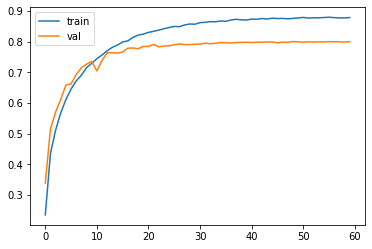

In [10]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='val')
plt.legend()
plt.show()

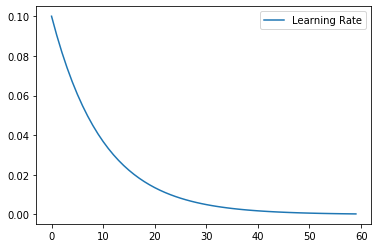

In [11]:
plt.plot(lrs.lrates, label='Learning Rate')
plt.legend()
plt.show()

# 3.Snapshot Ensemble 

## 3.1 Create Snapshots

In [0]:
# https://machinelearningmastery.com/snapshot-ensemble-deep-learning-neural-network/
class SnapshotEnsemble(Callback):
  def __init__(self, n_epochs, n_cycles, lrate_max, verbose=0):
    self.epochs = n_epochs
    self.cycles = n_cycles
    self.lr_max = lrate_max
    self.lrates = list()

  def cosine_annealing(self, epoch, n_epochs, n_cycles, lrate_max):
    epochs_per_cycle = n_epochs // n_cycles
    cos_inner = (np.pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
    return lrate_max/2 * (np.cos(cos_inner) + 1)

  def on_epoch_begin(self, epoch, logs={}):
    lr = self.cosine_annealing(epoch, self.epochs, self.cycles, self.lr_max)
    print(f'epoch {epoch+1}, lr {lr}')
    K.set_value(self.model.optimizer.lr, lr)
    self.lrates.append(lr)

  def on_epoch_end(self, epoch, logs={}):
    epochs_per_cycle = n_epochs // n_cycles
    if epoch != 0 and (epoch + 1) % epochs_per_cycle == 0:
      filename = f"snapshot_model_{int((epoch+1) / epochs_per_cycle)}.h5"
      self.model.save(filename)
      print(f'>saved snapshot {filename}, epoch {epoch}')

In [13]:
%%time
model2 = my_model()
model2.compile('sgd', loss='categorical_crossentropy', metrics=['accuracy'])

n_epochs = 60
n_cycles = n_epochs / 20
ca = SnapshotEnsemble(n_epochs, n_cycles, 0.1)

hist2 = model2.fit(trainX, trainY_cat, validation_data=(testX, testY_cat), epochs=n_epochs, batch_size = batch_size, callbacks=[ca])

Train on 50000 samples, validate on 10000 samples
Epoch 1/60
epoch 1, lr 0.1
50000/50000 [==============================] - 10s 201us/step - loss: 2.1095 - acc: 0.2128 - val_loss: 1.8017 - val_acc: 0.3512
Epoch 2/60
epoch 2, lr 0.0993844170297569
50000/50000 [==============================] - 9s 189us/step - loss: 1.6153 - acc: 0.4106 - val_loss: 1.4958 - val_acc: 0.4643
Epoch 3/60
epoch 3, lr 0.09755282581475769
50000/50000 [==============================] - 9s 189us/step - loss: 1.4161 - acc: 0.4840 - val_loss: 1.2719 - val_acc: 0.5441
Epoch 4/60
epoch 4, lr 0.09455032620941839
50000/50000 [==============================] - 9s 189us/step - loss: 1.2624 - acc: 0.5491 - val_loss: 1.1059 - val_acc: 0.6137
Epoch 5/60
epoch 5, lr 0.09045084971874738
50000/50000 [==============================] - 10s 194us/step - loss: 1.1411 - acc: 0.5953 - val_loss: 0.9912 - val_acc: 0.6518
Epoch 6/60
epoch 6, lr 0.08535533905932738
50000/50000 [==============================] - 10s 191us/step - loss: 1.

In [14]:
_, train_acc2 = model2.evaluate(trainX, trainY_cat)
_, val_acc2 = model2.evaluate(testX, testY_cat)
print('Train: %.3f, Test: %.3f' % (train_acc2, val_acc2))

10000/10000 [==============================] - 1s 73us/step
Train: 0.990, Test: 0.814


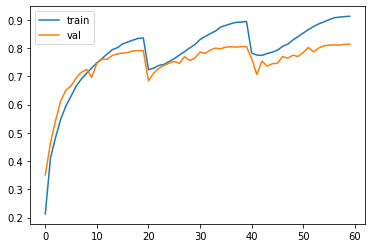

In [15]:
plt.plot(hist2.history['acc'], label='train')
plt.plot(hist2.history['val_acc'], label='val')
plt.legend()
plt.show()

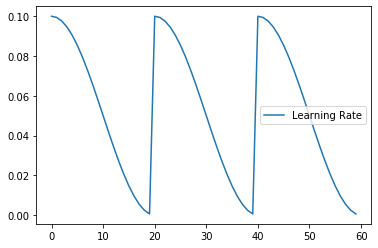

In [16]:
plt.plot(ca.lrates, label='Learning Rate')
plt.legend()
plt.show()

## 3.2 Make Ensemble Prediction

In [0]:
# load models from file
def load_all_models(n_models):
	all_models = list()
	for i in range(n_models):
		# define filename for this ensemble
		filename = 'snapshot_model_' + str(i + 1) + '.h5'
		# load model from file
		model = load_model(filename)
		# add to list of members
		all_models.append(model)
		print('>loaded %s' % filename)
	return all_models

In [0]:
# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
	# make predictions
	yhats = [model.predict(testX) for model in members]
	yhats = np.array(yhats)
	# sum across ensemble members
	summed = np.sum(yhats, axis=0)
	# argmax across classes
	result = np.argmax(summed, axis=1)
	return result

In [0]:
# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
	# select a subset of members
	subset = members[:n_members]
	# make prediction
	yhat = ensemble_predictions(subset, testX)
	# calculate accuracy
	return accuracy_score(testy, yhat)

In [20]:
members = load_all_models(3)
members = list(reversed(members)) 

>loaded snapshot_model_1.h5
>loaded snapshot_model_2.h5
>loaded snapshot_model_3.h5


In [21]:
# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()
for i in range(1, len(members)+1):
	# evaluate model with i members
	ensemble_score = evaluate_n_members(members, i, testX, np.argmax(testY_cat, axis=1))
	# evaluate the i'th model standalone
	_, single_score = members[i-1].evaluate(testX, testY_cat, verbose=0)
	# summarize this step
	print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
	ensemble_scores.append(ensemble_score)
	single_scores.append(single_score)
# summarize average accuracy of a single final model
print('Accuracy %.3f (%.3f)' % (np.mean(single_scores), np.std(single_scores)))

> 1: single=0.814, ensemble=0.814
> 2: single=0.806, ensemble=0.816
> 3: single=0.791, ensemble=0.816
Accuracy 0.804 (0.010)
